# Selección de clientes con Active Federated Learning - MNIST

En este notebook vamos a utilizar nuestro modelo de entrenamiento en Aprendizaje Federado utilizando AFL como algoritmo de selección de clientes [1] sobre el dataset de MNIST, que es un conjunto de imágenes de dígitos manuscritos del 0 al 9 [2]. Se trata de un problema de visión por computador al que usaremos para comparar el rendimiento del método de selección AFL frente al convencional.

> [1] https://arxiv.org/abs/1909.12641.
>
> [2] http://yann.lecun.com/exdb/mnist.

In [ ]:
# install FLEXible framework if not installed
try:
    import flex
    print("FLEXible is installed.")
except:
    print("FLEXible is not installed.\nInstalling dependency flexible-fl...")
    !pip install flexible-fl

FLEXible is not installed.
Installing dependency flexible-fl...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
  Created wheel for cardinality: filename=cardinality-0.1.1-py3-none-any.whl size=2587 sha256=d97208023c7a8dba4a122fc17ae779f38b7a52859e00af522e6e4f7981cb9116
  Stored in directory: /root/.cache/pip/wheels/b8/19/d1/2665c004b583a7d1880fa59055a3e462d6e35841a01b57010b
Successfully built cardinality


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(loss, accuracy):
    # Example data
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'g', label='Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

In [ ]:
import torch

# select device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'cpu'

In [ ]:
from flex.datasets import load
from torchvision import transforms

flex_dataset, test_data = load("federated_emnist", return_test=True, split="digits")

# Assign test data to server_id
server_id = "server"
flex_dataset[server_id] = test_data

mnist_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

Downloading...
From (original): https://drive.google.com/uc?id=1fl9fRPPxTUxnC56ACzZ8JiLiew0SMFwt
From (redirected): https://drive.google.com/uc?id=1fl9fRPPxTUxnC56ACzZ8JiLiew0SMFwt&confirm=t&uuid=b7ecfe48-54cc-45ee-a2f5-f3e96734fe67
To: /content/emnist-digits.mat
100%|██████████| 90.7M/90.7M [00:04<00:00, 19.7MB/s]
[sultan]: md5 -q ./emnist-digits.mat;
DEBUG:sultan:md5 -q ./emnist-digits.mat;
[sultan]: Unable to run 'md5 -q ./emnist-digits.mat;'
CRITICAL:sultan:Unable to run 'md5 -q ./emnist-digits.mat;'
[sultan]: --{ TRACEBACK }----------------------------------------------------------------------------------------------------
CRITICAL:sultan:--{ TRACEBACK }----------------------------------------------------------------------------------------------------
[sultan]: | NoneType: None
CRITICAL:sultan:| NoneType: None
[sultan]: | 
CRITICAL:sultan:| 
[sultan]: -------------------------------------------------------------------------------------------------------------------
CRITICAL:sulta

Usamos el decorador `@init_model_server` para inicializar el modelo en el servidor. Aprovechamos esta fase para simplemente definir nuestra arquitectura de red así como el optimizador y la función de pérdida.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from flex.pool import init_server_model
from flex.pool import FlexPool
from flex.model import FlexModel


# Simple two Fully-Connected layer net
class SimpleNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        # return logits
        return x


@init_server_model
def build_server_model():
    server_flex_model = FlexModel()

    server_flex_model["model"] = SimpleNet()
    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model


flex_pool = FlexPool.client_server_pool(
    flex_dataset, server_id=server_id, init_func=build_server_model
)

clients = flex_pool.clients
servers = flex_pool.servers
aggregators = flex_pool.aggregators

print(
    f"Number of nodes in the pool {len(flex_pool)}: {len(servers)} server plus {len(clients)} clients. The server is also an aggregator"
)

Number of nodes in the pool 3580: 1 server plus 3579 clients. The server is also an aggregator


Para comparar nuestro modelo con selección AFL, vamos a primero construir un método de selección de clientes aleatorio uniforme, por ejemplo, de $20$ clientes por ronda. Más adelante, implementaremos la selección con AFL con $m=20$ clientes por ronda.

In [ ]:
# Select clients
clients_per_round = 20
selected_clients_pool = clients.select(clients_per_round)
selected_clients = selected_clients_pool.clients

print(f'Server node is indentified by key "{servers.actor_ids[0]}"')
print(
    f"Selected {len(selected_clients.actor_ids)} client nodes of a total of {len(clients.actor_ids)}"
)

Server node is indentified by key "server"
Selected 20 client nodes of a total of 3579


Utilizamos el decorador `@deploy_server_model` para distribuir el modelo del servidor a los clientes. Usamos `map` sobre los clientes seleccionados: `selected_clients`.

In [ ]:
from flex.pool import deploy_server_model
import copy


@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    return copy.deepcopy(server_flex_model)


servers.map(copy_server_model_to_clients, selected_clients)

Implementamos la función de training para el que cada cliente avanza un número $n$ de pasos del optimizador (En este caso SGD-Adam [1]) sobre un _batch_ de $b$ imágenes. En nuestro caso, utilizaremos los mismo parámetros que en el ejemplo de FLEX [2]: $n=5, b=20$.

> [1] https://arxiv.org/abs/1412.6980.
>
> [2] [Federated MNIST PT Example](https://github.com/FLEXible-FL/FLEXible/blob/main/notebooks/Federated%20MNIST%20PT%20example%20with%20flexible%20decorators.ipynb)

In [ ]:
from flex.data import Dataset
from torch.utils.data import DataLoader


def train(client_flex_model: FlexModel, client_data: Dataset):
    train_dataset = client_data.to_torchvision_dataset(transform=mnist_transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=20)
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]
    for _ in range(5):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()


selected_clients.map(train)

Con el decorador `@collect_clients_weights` recuperamos los pesos de PyTorch de cada cliente seleccionado para esa ronda. En el caso de PyTorch, el modelo devuelve los pesos en forma de un diccionario con `state_dict` para el que cada nombre representa una capa de la red y sus parámetros, lo que hacemos será devolver una lista con los valores de ese diccionario correspondientes a los pesos de la red entera.

In [ ]:
from flex.pool import collect_clients_weights


@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    weight_dict = client_flex_model["model"].state_dict()
    return [weight_dict[name] for name in weight_dict]


aggregators.map(get_clients_weights, selected_clients)

Utilizamos el decorador `@aggregate_weights` para poder agregar los pesos que hemos recuperado de los clientes en la fase anterior computando la media de los pesos, conocido como agregador FedAvg, donde realizamos la media por columnas para cada capa de pesos.

In [ ]:
from flex.pool import aggregate_weights
import tensorly as tl

tl.set_backend("pytorch")


@aggregate_weights
def aggregate_with_fedavg(list_of_weights: list):
    agg_weights = []
    for layer_index in range(len(list_of_weights[0])):
        weights_per_layer = [weights[layer_index] for weights in list_of_weights]
        weights_per_layer = tl.stack(weights_per_layer)
        agg_layer = tl.mean(weights_per_layer, axis=0)
        agg_weights.append(agg_layer)
    return agg_weights


# Aggregate weights
aggregators.map(aggregate_with_fedavg)

Finalmente, agregamos los pesos al modelo de nuestro servidor/agregador. Sencillamente, para cada capa de nuestro modelo, realizamo una copia del nuevo que hemos agregado en la fase anterior.

In [ ]:
from flex.pool import set_aggregated_weights


@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    with torch.no_grad():
        weight_dict = server_flex_model["model"].state_dict()
        for layer_key, new in zip(weight_dict, aggregated_weights):
            weight_dict[layer_key].copy_(new)


aggregators.map(set_agreggated_weights_to_server, servers)

Podemos evaluar el modelo del servidor sobre el dataset de test que hemos definido anteriormente que residía en el mismo servidor. Para ello, definimos una función `evaluate_global_model` que obtenga las predicciones del modelo con el dataset de test y devuelva las metricas resultantes, que en este caso son simplemente la pérdida y la _accuracy_.

In [ ]:
def evaluate_global_model(server_flex_model: FlexModel, test_data: Dataset):
    model = server_flex_model["model"]
    model.eval()
    test_loss = 0
    test_acc = 0
    total_count = 0
    model = model.to(device)
    criterion = server_flex_model["criterion"]
    # get test data as a torchvision object
    test_dataset = test_data.to_torchvision_dataset(transform=mnist_transforms)
    test_dataloader = DataLoader(
        test_dataset, batch_size=256, shuffle=True, pin_memory=False
    )
    losses = []
    with torch.no_grad():
        for data, target in test_dataloader:
            total_count += target.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            losses.append(criterion(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            test_acc += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()

    test_loss = sum(losses) / len(losses)
    test_acc /= total_count
    return test_loss, test_acc


metrics = servers.map(evaluate_global_model)
print("Loss (test):", metrics[0][0])
print("Accuracy (test):", metrics[0][1])

Loss (test): 1.5645130637345042
Accuracy (test): 0.559


Para poder repetir esto en diferentes rondas, definimos la función `train_n_rounds` que aplica las funciones vistas de forma iterativa.

In [ ]:
def train_n_rounds(n_rounds, clients_per_round=20):
    pool = FlexPool.client_server_pool(
        fed_dataset=flex_dataset, server_id=server_id, init_func=build_server_model
    )
    losses = []
    accuracies = []
    for i in range(n_rounds):
        print(f"\nRunning round: {i+1} of {n_rounds}")
        selected_clients_pool = pool.clients.select(clients_per_round)
        selected_clients = selected_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")
        # Deploy the server model to the selected clients
        pool.servers.map(copy_server_model_to_clients, selected_clients)
        # Each selected client trains her model
        selected_clients.map(train)
        # The aggregador collects weights from the selected clients and aggregates them
        pool.aggregators.map(get_clients_weights, selected_clients)
        pool.aggregators.map(aggregate_with_fedavg)
        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")

    return losses, accuracies


Running round: 1 of 15
Selected clients for this round: 20
Server: Test acc: 0.6404, test loss: 1.5846

Running round: 2 of 15
Selected clients for this round: 20
Server: Test acc: 0.7919, test loss: 0.9024

Running round: 3 of 15
Selected clients for this round: 20
Server: Test acc: 0.8154, test loss: 0.6758

Running round: 4 of 15
Selected clients for this round: 20
Server: Test acc: 0.8366, test loss: 0.5520

Running round: 5 of 15
Selected clients for this round: 20
Server: Test acc: 0.8534, test loss: 0.4851

Running round: 6 of 15
Selected clients for this round: 20
Server: Test acc: 0.8637, test loss: 0.4398

Running round: 7 of 15
Selected clients for this round: 20
Server: Test acc: 0.8734, test loss: 0.4079

Running round: 8 of 15
Selected clients for this round: 20
Server: Test acc: 0.8691, test loss: 0.4078

Running round: 9 of 15
Selected clients for this round: 20
Server: Test acc: 0.8756, test loss: 0.3911

Running round: 10 of 15
Selected clients for this round: 20
Ser

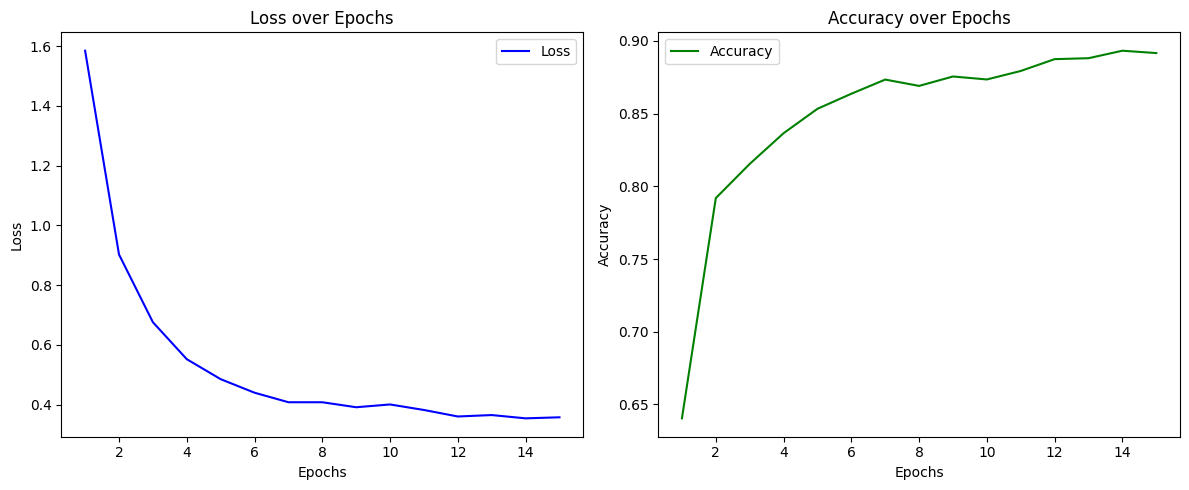

In [ ]:
losses, accuracies = train_n_rounds(15)
plot_loss_accuracy(losses, accuracies)

# Federar MNIST manualmente

Federamos manualmente, usando las primitivas de FLEX, el dataset de MNIST traído desde la librería PyTorch.

Dado que el algoritmo de aproximación de valores de Shapley GTG-Shapley necesita de un conjunto de validación $\mathcal D_{\text{val}}$, separaremos el dataset de entrenamiento en dos subconjuntos de datos: uno de entrenamieto y otro de validación, siendo el tamaño del de validación un $20\%$ de los datos totales de entrenamiento.

$$
\mathcal D_\text{T} = \mathcal D_\text{train} \cup \mathcal D_\text{val}\\
\begin{cases}
N &= |\mathcal D_\text{T}|,\\
N_\text{val} &= \lfloor 0.2 \times N\rfloor,\\
N_\text{train} &= N-N_\text{val}
\end{cases}
$$

Para la distribución de los datos en un escenario de FL, establecemos un número de $K=300$ nodos sin contar el servidor central.

In [ ]:
import math

from torchvision import datasets, transforms
from torch.utils.data import random_split

from flex.data import Dataset, FedDatasetConfig, FedDataDistribution

mnist_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_data = datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=None  # we apply them later in training process
)

test_data = datasets.MNIST(
    root='.',
    train=False,
    download=True,
    transform=None  # we apply them later in training process
)

# split train data into training and validation datasets (val data ~ 20% of train data)
val_len = math.floor(0.2 * len(train_data))
train_len = len(train_data) - val_len

train_data, val_data = random_split(train_data, [train_len, val_len])

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = 300

flex_dataset = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data), config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset[server_id] = Dataset.from_torchvision_dataset(test_data)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6046422.83it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 160470.77it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1509301.88it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3591728.65it/s]
/usr/local/lib/python3.10/dist-packages/flex/data/dataset.py:130: RuntimeWarning: The input dataset and arguments are not explicitly supported, therefore they might not work as expected.
  warnings.warn(


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Inicializamos el modelo central en el servidor. El modelo de aprendizaje será un MLP (_Multi-Layer Perceptron_) de dos capas ocultas y con una función de activación ReLU para la primera capa y LogSoftmax en la capa de salida (aplicada por la función de pérdida o _criterion_ Cross-Entropy Loss).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from flex.pool import init_server_model
from flex.pool import FlexPool
from flex.model import FlexModel

# Simple Multi-Layer Perceptron
class SimpleNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        # return logits
        return x


@init_server_model
def build_server_model():
    server_flex_model = FlexModel()

    server_flex_model["model"] = SimpleNet()
    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model


flex_pool = FlexPool.client_server_pool(
    flex_dataset, server_id=server_id, init_func=build_server_model
)

clients = flex_pool.clients
servers = flex_pool.servers
aggregators = flex_pool.aggregators

print(
    f"Number of nodes in the pool {len(flex_pool)}: {len(servers)} server plus {len(clients)} clients. The server is also an aggregator"
)

Number of nodes in the pool 301: 1 server plus 300 clients. The server is also an aggregator


# Asignar $\mathcal D_\text{val}$ a los agregadores

Creamos una función `save_validation_data` que guardará el conjunto de validación que hemos creado en los modelos de los agregadores.

In [ ]:
from copy import deepcopy

def save_validation_data(agg_flex_model: FlexModel, _test_data: Dataset, **kwargs):
    agg_flex_model["val_data"] = deepcopy(kwargs["val_data"])

# aggregators.map(save_validation_data, val_data=val_data)

# Agregar modelos locales usando FedAvg con pesos proporcionales a $n_k$

Cuando agregamos los modelos locales de los clientes existen dos opciones de agregación: agregar de forma uniforme todos los clientes $k\in S_t$ (como se realiza en FedAvg [1]) o asignando un peso a cada cliente $k \in S_t$ proporcional al tamaño de su conjunto de datos $n_k$.

Para lograr este último redefinimos los pasos de __recolección de los pesos de los clientes__ y de __agregación__ para que:
1. Por un lado, además de los pesos del modelo local $w_k^{(t)}$, se recupere su peso proporcional a $n_k$.
2. Y por otro lado, agregar los modelos como una suma ponderada con los pesos proporcionales a $n_k$.

> [1] https://arxiv.org/abs/1602.05629.

In [ ]:
from flex.pool import collect_clients_weights

@collect_clients_weights
def get_clients_weights_with_len_weights(client_flex_model: FlexModel):
    weight_dict = client_flex_model["model"].state_dict()
    return [weight_dict[name] for name in weight_dict], client_flex_model["weight"]

In [ ]:
def aggregate(client_model_weights: list, client_weights: list):
    # normalize client weights
    total_weights = sum(client_weights)
    norm_client_weights = torch.Tensor([w / total_weights for w in client_weights]).to(device)

    agg_weights = []
    for layer_index in range(len(client_model_weights[0])):
        weighted_sum = torch.zeros(client_model_weights[0][layer_index].shape).to(device)

        # weighted average for each client in layer
        for client_idx in range(len(client_model_weights)):
            weighted_sum += norm_client_weights[client_idx] * client_model_weights[client_idx][layer_index].to(device)

        agg_weights.append(weighted_sum)

    return agg_weights

In [ ]:
from flex.pool import aggregate_weights
import tensorly as tl
import numpy as np

tl.set_backend("pytorch")

@aggregate_weights
def model_average_aggregate(weights: list):
    # separate client weights from model weights
    client_model_weights = list(map(lambda w: w[0], weights))
    client_weights = list(map(lambda w: w[1], weights))

    return aggregate(client_model_weights, client_weights)

Definimos un paso inicial (no contenido en el _training loop_) en el que inicializamos los pesos de agregación de cada cliente para que sean $n_k$.

In [ ]:
def init_client_weights(client_flex_model: FlexModel, client_data: Dataset):
    """
    Save client weights as their dataset length.
    """
    client_flex_model["weight"] = float(len(client_data))

# Función de utilidad $\mathcal U(w)$

El algoritmo de aproximación de valores Shapley GTG-Shapley define una función $\mathcal U(w) := -\mathcal L(w;\mathcal D_\text{val})$ que estima la utilidad de un modelo $w$ sobre el conjunto de validación $\mathcal D_\text{val}$ negando el valor de pérdida sobre este último. De esta manera, se puede dar una función valuación a un modelo agregado que es creciente cuanto mejor predice el conjunto de validación.

In [ ]:
import torch.nn as nn
from typing import Callable

def utility(model: nn.Module, test_data: Dataset, criterion: Callable):
    model.eval()
    test_loss = 0
    test_acc = 0
    total_count = 0
    model = model.to(device)
    # get test data as a torchvision object
    test_dataset = test_data.to_torchvision_dataset(transform=mnist_transforms)
    test_dataloader = DataLoader(
        test_dataset, batch_size=256, shuffle=True, pin_memory=False
    )
    losses = []
    with torch.no_grad():
        for data, target in test_dataloader:
            total_count += target.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            losses.append(criterion(output, target).item())

    test_loss = sum(losses) / len(losses)
    return 1 - test_loss

# Test de convergencia

En el algoritmo GTG-Shapley, se computan los valores de Shapley (contribución marginal media) para cada cliente $k \in S_t$ sobre un número de determinado de iteraciones o hasta que los valores converjan computando el cambio medio en un número de iteraciones determinado. Definimos por tanto una función para comprobar si los valores de Shapley de un cliente han convergido en un número de mínimo $20$ iteraciones y para un umbral inferior de $1\%$.

In [ ]:
def convergenceTest(values):
    """
    Compute average change in last 20 iterations and if it less that 1% it has converged
    """
    if len(values) < 20:
        return False
    else:
        last_vals = torch.Tensor(values[-20:]).to(device)
        last_val = torch.Tensor([values[-1]]).to(device)

        # avoid division by zero
        if last_val < 1e-6:
            return False

        return (
            torch.mean(
                torch.abs(last_vals - last_val)
            )
            / torch.abs(last_val)
        ) < 0.01

# GTG-SHAPLEY VALUES

Implementamos el algoritmo de aproximación de valores de Shapley GTG-Shapley [1]. Este algoritmo depende de la función de agregación $F$ del servidor, para lo que definimos además una función que obtenga el modelo agregado dado una lista de modelos de los clientes y sus ponderaciones.

Los hiperparámetros de este algoritmo son por un lado el máximo de iteraciones $T$ para cada cliente y el umbral de error $ϵ$ para considerar la contribución al modelo agregado (si la contribución es menor que $\epsilon$ los valores de Shapley $SV_k$ son directamente $0$). En nuestro caso, daremos $T=20 \times M$ iteraciones ($20$ por cliente seleccionado) y un umbral $\epsilon=10^{-4}$.

> [1] https://arxiv.org/abs/2109.02053.

In [ ]:
import torch.nn as nn
from copy import deepcopy
from typing import List

def get_aggregated_model(server_model: nn.Module, client_models: List[nn.Module], client_weights: List[float]):
    client_model_weights =  []
    for k in client_models:
        weight_dict = k.state_dict()
        client_model_weights.append([weight_dict[name] for name in weight_dict])

    # get aggregated weights
    aggregated_weights = aggregate(client_model_weights, client_weights)

    # copy original model
    agg_model = deepcopy(server_model)

    # set aggregated weights
    with torch.no_grad():
        weight_dict = agg_model.state_dict()
        for layer_key, new in zip(weight_dict, aggregated_weights):
            weight_dict[layer_key].copy_(new)

    return agg_model

In [ ]:
from typing import List

MAX_ITERATIONS = 30
EPSILON = 1e-4

def shapley_values_gtg(agg_model: FlexModel, client_flex_models: List[FlexModel], **kwargs):
    """
    client_states - list of client states
    weights - weights for averaging (uniform by default)

    computes shapley values for the client updates on validation dataset
    """
    # get arguments
    criterion = agg_model["criterion"]
    d_val = agg_model["val_data"]
    current_model = agg_model["model"]
    uniform_weights = kwargs["uniform"] if "uniform" in kwargs.keys() else True

    num_clients = len(client_flex_models)

    # parse weights for averaging model
    weights = [client_flex_models[k]["weight"] for k in client_flex_models]
    if uniform_weights:
        # uniform weights
        weights = [1 / num_clients] * num_clients
    weights = np.array(weights)
    wtsum = np.sum(weights)
    # normalize weights
    weights /= wtsum

    shapley_values = [[0] for i in range(num_clients)]
    converged = False

    T = MAX_ITERATIONS * num_clients
    t = 0
    threshold = EPSILON

    # initial server model t loss
    v_init = utility(current_model, d_val, criterion)

    # final model t+1 loss
    model_final = get_aggregated_model(
        current_model,
        [client_flex_models[k]["model"] for k in client_flex_models],
        weights,
    )
    v_final = utility(model_final, d_val, criterion)

    # if difference in loss on aggregated model is lower than threshold, SVs are 0 (contribution is negligible)
    if np.abs(v_final - v_init) < threshold:
        epsilon = 1e-9
        return [epsilon for i in range(num_clients)]

    # id-independent list of client models
    client_models = list(client_flex_models.values())

    while not converged and t < T:
        for k in range(num_clients):
            t += 1

            # get all possible combinations of selected clients having k in idx=0
            client_permutation = np.concatenate(
                (
                    np.array([k]),
                    np.random.permutation(
                        [i for i in range(num_clients) if i != k]
                    )
                )
            ).astype(int)

            v_j = v_init

            for j in range(num_clients):
                if np.abs(v_final - v_j) < threshold:
                    v_jp1 = v_j
                else:
                    subset = client_permutation[: (j + 1)]
                    client_models_subset = [client_models[i]["model"] for i in subset]
                    weights_subset = [weights[i] for i in subset]
                    # aggregate the subset-clients
                    model_subset = get_aggregated_model(current_model, client_models_subset, weights_subset)
                    v_jp1 = utility(model_subset, d_val, criterion)

                phi_old = shapley_values[client_permutation[j]][-1]
                phi_new = ((t - 1) * phi_old + (v_jp1 - v_j)) / t
                shapley_values[client_permutation[j]].append(phi_new)
                v_j = v_jp1

        flag = True
        shapley_avg = np.mean(shapley_values, axis=0)
        if not convergenceTest(shapley_avg):
            flag = False

        if flag:
            converged = True

    if not converged:
        print("not converged in SV GTG")

    final_shapley_values = [shapley_values[i][-1] for i in range(num_clients)]
    return final_shapley_values

In [ ]:
from torch import topk

from flex.data import Dataset

def train_n_rounds_greedy(n_rounds, clients_per_round=20):
    pool = FlexPool.client_server_pool(
        fed_dataset=flex_dataset, server_id=server_id, init_func=build_server_model
    )

    num_clients = len(pool.clients)

    # initialize client length weights
    pool.clients.map(init_client_weights)

    # assign validation dataset to server
    flex_val_data = Dataset.from_torchvision_dataset(val_data)
    pool.servers.map(save_validation_data, val_data=flex_val_data)

    UCB = [0 for i in range(num_clients)]
    SV = [0 for i in range(num_clients)]
    SV_curr = [0 for i in range(num_clients)]
    N_t = [0 for i in range(num_clients)]

    losses = []
    accuracies = []
    for i in range(n_rounds):
        print(f"\nRunning round: {i+1} of {n_rounds}")

        # select clients to transmit weights to
        # initially sample every client atleast once (RR)
        selected = [False for _ in range(num_clients)]
        if i < np.floor(num_clients / clients_per_round):
            print("RR round")
            for idx in range(i * clients_per_round, (i + 1) * clients_per_round):
                selected[idx] = True
                N_t[idx] += 1
        elif i == np.floor(num_clients / clients_per_round):
            print("Last RR round")
            for idx in range(i * clients_per_round, num_clients):
                selected[idx] = True
                N_t[idx] += 1

            remaining_selections = clients_per_round * (i + 1) - num_clients
            if remaining_selections > 0:
                unselected_indices = list(range(0, i * clients_per_round))
                selected_indices_subset = np.random.choice(
                    unselected_indices, size=remaining_selections, replace=False
                )

                for idx in selected_indices_subset:
                    selected[idx] = True
                    N_t[idx] += 1
        else:
            # UCB Greedy Selection (select clients with highest SV)
            _, selected_indices = topk(torch.Tensor(UCB), clients_per_round)
            print("Best selected: ", selected_indices)
            for idx in selected_indices.tolist():
                selected[idx] = True
                N_t[idx] += 1

        # take selected clients
        selected_indices = [index for index, value in enumerate(selected) if value]
        selected_clients_pool = pool.clients.select(lambda actor_id, actor_roles: actor_id in selected_indices)
        selected_clients = selected_clients_pool.clients

        print(f"Selected clients for this round: {len(selected_clients)}")

        # Deploy the server model to the selected clients
        pool.servers.map(copy_server_model_to_clients, selected_clients)

        # Each selected client trains its model
        selected_clients.map(train)

        # The aggregador collects weights from the selected clients and aggregates them
        pool.aggregators.map(get_clients_weights_with_len_weights, selected_clients)
        pool.aggregators.map(model_average_aggregate)

        # compute SV values for each selected client in the server
        shapley_values = pool.aggregators.map(shapley_values_gtg, selected_clients)[0]

        print("GTG-Shapley values: ", shapley_values)

        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)

        # compute the cumulative SV of each client
        counter = 0
        for k in range(num_clients):
            if selected[k]:
                SV_curr[k] = shapley_values[counter]

                # previous num selections weight/penalty
                prev_wt = (N_t[k] - 1) / N_t[k]
                # current num selections weight/penalty
                curr_wt = 1 - prev_wt   # 1 / N_t[k]

                # previous cumulative SV
                prev_sv = SV[k]

                # t-round SV
                curr_sv = SV_curr[k]

                # compute new cumulative SV
                SV[k] = prev_wt * prev_sv + curr_wt * curr_sv

                counter += 1
            else:
                SV_curr[k] = 0

            UCB[k] = SV[k]

        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]

        losses.append(loss)
        accuracies.append(acc)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")

    return losses, accuracies

In [ ]:
losses, accuracies = train_n_rounds_greedy(150, clients_per_round=3)
plot_loss_accuracy(losses, accuracies)


Running round: 1 of 150
RR round
Selected clients for this round: 3
GTG-Shapley values:  [0.28082140926894444, 0.4222117865943136, 0.3694769236454486]
Server: Test acc: 0.6944, test loss: 1.2053

Running round: 2 of 150
RR round
Selected clients for this round: 3
GTG-Shapley values:  [0.18638246955601034, 0.20640359430931496, 0.18927515332097333]
Server: Test acc: 0.8440, test loss: 0.6269

Running round: 3 of 150
RR round
Selected clients for this round: 3
GTG-Shapley values:  [0.03533198635387324, 0.04641286239194051, 0.047825965233969966]
Server: Test acc: 0.8573, test loss: 0.4869

Running round: 4 of 150
RR round
Selected clients for this round: 3
GTG-Shapley values:  [0.026316463826516718, 0.014057185542378151, 0.01609528946417563]
Server: Test acc: 0.8738, test loss: 0.4360

Running round: 5 of 150
RR round
Selected clients for this round: 3
GTG-Shapley values:  [0.005235784956024783, 0.018159265878111182, 0.011159723924648438]
Server: Test acc: 0.8849, test loss: 0.3970

Runni

In [ ]:
losses, accuracies = train_n_rounds(15, 200)
plot_loss_accuracy(losses, accuracies)

In [ ]:
losses, accuracies = train_n_rounds_afl(15, 200)
plot_loss_accuracy(losses, accuracies)

In [ ]:
ALPHA3 = 0.4
losses, accuracies = train_n_rounds_afl(15, 200)
plot_loss_accuracy(losses, accuracies)